# Análisis geoespacial


## Objetivo de esta etapa

En esta sección, vamos a realizar un análisis espacial para determinar cómo varía la demanda geográfica en diferentes zonas de la ciudad. Esto ayudará a identificar áreas con alta y baja demanda y entender las rutas y frecuencias del transporte, a lo largo del tiempo.

#### Recoleción de datos

Este conjunto de datos proviene de fuentes oficiales proporcionadas por el municipio de General Pueyrredón y el Ministerio de Transporte de la Nación, así como de los datos abiertos de la Nación Argentina. Los datos han sido recopilados de manera oficial y se utilizan con fines de análisis y evaluación. Los datos presentados aquí cumplen con los estándares de Protección de la Privacidad y Protección de la Propiedad Intelectual. No contienen información personal ni sensible de ningun tipo.

Desarrollo teorico: ver en [ [Google Docs](https://docs.google.com/document/d/1yzVlvsXcEtoXk6GwHifnI7rfyHre6SO6RGGLM6jcXNg/edit?usp=sharing) ]

UGR 2024 - Lic. en Ciencia de Datos - Braian D'Aleo

## Recolección de datos

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

from shapely.geometry import Point
from shapely.ops import unary_union

import imageio
import imageio.v2 as imageio

from IPython.display import Video

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib.ticker import FuncFormatter

from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

import warnings
warnings.filterwarnings('ignore')

## Preparación de datos

In [2]:
df = pd.read_csv("Datasets/sube-with-predictions.csv")
df

,DATE,DAY,MONTH,YEAR,COMPANY,LINE_ID,TICKETS
0,2020-01-01,1,1,2020,25 DE MAYO,501,315
1,2020-01-01,1,1,2020,PERALTA RAMOS,511,11463
2,2020-01-01,1,1,2020,PERALTA RAMOS,512,1889
3,2020-01-01,1,1,2020,25 DE MAYO,521,2729
4,2020-01-01,1,1,2020,25 DE MAYO,522,4010
...,...,...,...,...,...,...,...
48657,2024-12-31,31,12,2024,PERALTA RAMOS,581,6728
48658,2024-12-31,31,12,2024,PERALTA RAMOS,591,7552
48659,2024-12-31,31,12,2024,PERALTA RAMOS,593,4728
48660,2024-12-31,31,12,2024,BATAN,715,6894


## Analisis espacial

In [3]:
# Cargar el archivo GeoJSON usando geopandas
gdf = gpd.read_file('Datasets\paradas.geojson')

gdf['linea'] = gdf['linea'].replace('593CORTA', '593')
gdf['linea'] = gdf['linea'].replace('BATAN', '720')

gdf

,cartodb_id,linea,geometry
0,1,720,POINT (-57.54245 -38.00059)
1,2,720,POINT (-57.54245 -38.00059)
2,3,720,POINT (-57.54245 -38.00059)
3,4,720,POINT (-57.54245 -38.00059)
4,5,720,POINT (-57.54245 -38.00059)
...,...,...,...
10076,10077,717,POINT (-57.65495 -37.93991)
10077,10078,717,POINT (-57.65220 -37.94155)
10078,10079,717,POINT (-57.65220 -37.94155)
10079,10080,717,POINT (-57.64052 -37.94983)


In [4]:
gdf.rename(columns={'linea': 'LINE_ID'}, inplace=True)

gdf['LINE_ID'] = gdf['LINE_ID'].astype(int)

Uno de los problemas al trabajar con este mapa es que presenta dos rutas faltantes: la linea 715 y 720, que tienen practicamente el mismo recorrido se identifican como BATAN

In [5]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df[(df['YEAR'] == 2023) & (df['MONTH'] == 1) & (df['COMPANY'] == "BATAN")].head(10)

,DATE,DAY,MONTH,YEAR,COMPANY,LINE_ID,TICKETS
29035,2023-01-01,1,1,2023,BATAN,715,1707
29062,2023-01-02,2,1,2023,BATAN,715,6086
29089,2023-01-03,3,1,2023,BATAN,715,6809
29116,2023-01-04,4,1,2023,BATAN,715,7302
29143,2023-01-05,5,1,2023,BATAN,715,7786
29170,2023-01-06,6,1,2023,BATAN,715,7281
29197,2023-01-07,7,1,2023,BATAN,715,5254
29223,2023-01-08,8,1,2023,BATAN,715,3875
29250,2023-01-09,9,1,2023,BATAN,715,7690
29277,2023-01-10,10,1,2023,BATAN,715,7484


## Comparacion con informacion disponible

Para darle valos a los mapas, busquemos incompatibilidades entre LINE_ID

In [6]:
# Obtener los valores únicos de LINE_ID en ambos DataFrames
line_ids_df = df['LINE_ID'].unique()
line_ids_gdf = gdf['LINE_ID'].unique()

print(f"Valores únicos de LINE_ID en df: {len(line_ids_df)}")
print(f"Valores únicos de LINE_ID en gdf: {len(line_ids_gdf)}")

# Convertir los valores únicos a conjuntos para facilitar la comparación
set_line_ids_df = set(line_ids_df)
set_line_ids_gdf = set(line_ids_gdf)

# Identificar los LINE_IDs que están en df pero no en gdf
only_in_df = set_line_ids_df - set_line_ids_gdf
print(f"LINE_IDs en df pero no en gdf: {only_in_df}")

# Identificar los LINE_IDs que están en gdf pero no en df
only_in_gdf = set_line_ids_gdf - set_line_ids_df
print(f"LINE_IDs en gdf pero no en df: {only_in_gdf}")

Valores únicos de LINE_ID en df: 27
Valores únicos de LINE_ID en gdf: 26
LINE_IDs en df pero no en gdf: {554, 715}
LINE_IDs en gdf pero no en df: {720}


Bien, en el mapa no tenemos la informacion de la linea 715 y la 554.

En este caso la linea 554 la recrear ya que tiene recorridos similares a la linea 552 y 551.

La line 715 es exactamente igual a la 720, podrimaos convertir la 720 en 715. Vale aclarar que la linea 720 fue quitada del dataset por no presentar datos suficientes para su representación.

In [7]:
# Reemplazar el valor de LINE_ID 720 por 715
gdf.loc[gdf['LINE_ID'] == 720, 'LINE_ID'] = 715
gdf[gdf['LINE_ID'] == 715]

,cartodb_id,LINE_ID,geometry
0,1,715,POINT (-57.54245 -38.00059)
1,2,715,POINT (-57.54245 -38.00059)
2,3,715,POINT (-57.54245 -38.00059)
3,4,715,POINT (-57.54245 -38.00059)
4,5,715,POINT (-57.54245 -38.00059)
...,...,...,...
1975,1976,715,POINT (-57.70437 -38.02560)
1976,1977,715,POINT (-57.70437 -38.02560)
1977,1978,715,POINT (-57.72600 -38.03202)
1978,1979,715,POINT (-57.72600 -38.03202)


In [8]:
# Copiar los datos de la línea 551 para crear la nueva línea 554
line_554 = gdf[gdf['LINE_ID'] == 551].copy()
line_554['LINE_ID'] = 554

# Añadimos la nueva línea al GeoDataFrame
gdf = pd.concat([gdf, line_554], ignore_index=True)
gdf = gdf.sort_values(by='LINE_ID').reset_index(drop=True)
gdf[gdf['LINE_ID'] == 554]

,cartodb_id,LINE_ID,geometry
5267,6344,554,POINT (-57.55984 -37.96250)
5268,6352,554,POINT (-57.54483 -37.97014)
5269,6351,554,POINT (-57.54579 -37.96964)
5270,6350,554,POINT (-57.54773 -37.96862)
5271,6349,554,POINT (-57.54979 -37.96765)
...,...,...,...
5490,6415,554,POINT (-57.55808 -38.04439)
5491,6445,554,POINT (-57.56040 -38.01634)
5492,6379,554,POINT (-57.56538 -38.02052)
5493,6510,554,POINT (-57.56410 -38.04362)


# Mapa

Debido a que mi analisis se enfoca en la demanda total de transporte, opte por agrupar de forma mensual los totales de pasajeros transportados en cada linea de transporte.

In [9]:
# Creamos un nuevo DataFrame agrupado por LINE_ID, MONTH y YEAR, sumando los TICKETS
df_agrupado = df.groupby(['LINE_ID', 'MONTH', 'YEAR'], as_index=False)['TICKETS'].sum()

df_agrupado = df_agrupado.sort_values(by=['MONTH', 'YEAR', 'LINE_ID'])
order = ['MONTH', 'YEAR', 'LINE_ID', 'TICKETS']
df_agrupado = df_agrupado[order]
df_agrupado

,MONTH,YEAR,LINE_ID,TICKETS
0,1,2020,501,24866
60,1,2020,511,1062951
120,1,2020,512,176840
180,1,2020,521,269986
240,1,2020,522,389117
...,...,...,...,...
1379,12,2024,581,180718
1439,12,2024,591,209634
1499,12,2024,593,130151
1559,12,2024,715,193362


Comprobamos lo realizado

In [10]:
df_agrupado[(df_agrupado['MONTH'] == 1) & (df_agrupado['YEAR'] == 2023)]


,MONTH,YEAR,LINE_ID,TICKETS
3,1,2023,501,32114
63,1,2023,511,891536
123,1,2023,512,140566
183,1,2023,521,199958
243,1,2023,522,275889
303,1,2023,523,363799
363,1,2023,525,41795
423,1,2023,531,207912
483,1,2023,532,313340
543,1,2023,533,100016


## Exploración visual y encaje de puntos

In [11]:
# Convertimos el GeoDF a formato compatible con Plotly
gdf['lon'] = gdf.geometry.x
gdf['lat'] = gdf.geometry.y

# Creamos el mapa usando Plotly
fig = px.scatter_mapbox(gdf, lat="lat", lon="lon", hover_name="LINE_ID", color="LINE_ID",  # Usar una columna existente
                        zoom=12, height=500)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

Observemos el dataframe a resultante para GeoPandas

In [12]:
gdf

,cartodb_id,LINE_ID,geometry,lon,lat
0,2069,501,POINT (-57.57585 -38.10461),-57.575849,-38.104608
1,2009,501,POINT (-57.57344 -38.06877),-57.573445,-38.068766
2,2010,501,POINT (-57.57527 -38.07205),-57.575274,-38.072052
3,2011,501,POINT (-57.58461 -38.07968),-57.584605,-38.079681
4,2012,501,POINT (-57.59246 -38.08610),-57.592459,-38.086099
...,...,...,...,...,...
10304,9966,717,POINT (-57.61021 -37.96594),-57.610214,-37.965938
10305,9965,717,POINT (-57.61021 -37.96594),-57.610214,-37.965938
10306,9964,717,POINT (-57.57254 -37.98553),-57.572545,-37.985533
10307,9977,717,POINT (-57.75948 -37.92809),-57.759475,-37.928093


## Agrupación de puntos

El objetivo aqui es superponer la demanda en los recorridos, generando lineas y puntos de demanda mas claros visualmente. Esto se logro homogeinizando puntos dentro de radios de 100 metros. Ejemplo: Av. Pedro Luro, tiene paradas sobre ambas manos, esos waypoints debian convertirse en un unico waypoint. Este, se encargara de contener en una lista, todas las lineas unicas que por alli transiten. 

In [13]:
# Crear una copia del GeoDataFrame
gdf_copy = gdf.copy()

# Reproyectar a un CRS proyectado adecuado (por ejemplo, EPSG:3857)
gdf_copy = gdf_copy.to_crs(epsg=3857)

# Creamos un buffer de 100 metros alrededor de cada punto
gdf_copy['buffer'] = gdf_copy.geometry.buffer(100)  # 100 metros

# Unimos los buffers superpuestos
unary_union_buffers = unary_union(gdf_copy['buffer'].tolist())

# Extraemos los centroides de los buffers unidos
centroids = [geom.centroid for geom in unary_union_buffers.geoms]

# Creamos nuevo GeoDF con los centroides
centroids_gdf = gpd.GeoDataFrame(geometry=centroids, crs=gdf_copy.crs)

# Inicializar listas para almacenar los puntos combinados y los LINE_ID que pasan por allí
combined_points = []
combined_line_ids = []

# Iteraramos sobre los centroides y agrupamos los puntos originales
for centroid in centroids_gdf.geometry:
    # Seleccionamos los puntos que están dentro del buffer de 100 metros del centroide
    points_within_buffer = gdf_copy[gdf_copy.geometry.within(centroid.buffer(100))]
    # Obtenemos los LINE_ID que pasan por el buffer y asegurarse de que sean únicos
    line_ids = list(set(points_within_buffer['LINE_ID'].tolist()))
    combined_points.append(centroid)
    combined_line_ids.append(line_ids)

# Creamos un nuevo GeoDF con los puntos combinados y los LINE_ID asociados
combined_gdf = gpd.GeoDataFrame({'geometry': combined_points, 'LINE_ID': combined_line_ids}, crs=gdf_copy.crs)

# Reproyectar de nuevo al CRS original
combined_gdf = combined_gdf.to_crs(epsg=4326)

# Imprimir y evaluamos la estructura del nuevo GeoDF
print(combined_gdf.head())

# Creamos un DF plano para Plotly
plot_data = []
for idx, row in combined_gdf.iterrows():
    plot_data.append({
        'lon': row['geometry'].x,
        'lat': row['geometry'].y,
        # Convertimos la lista de LINE_ID a una cadena separada por comas
        'LINE_ID': ', '.join(map(str, row['LINE_ID']))  
    })

plot_df = pd.DataFrame(plot_data)

# Crear el mapa usando Plotly
fig = px.scatter_mapbox(plot_df, lat="lat", lon="lon", zoom=11, height=500, text='LINE_ID')

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": -38.077591762587275, "lon": -57.59587897840447},
    mapbox_zoom=11,
    mapbox_bearing=-61.600000000000136,
    mapbox_pitch=58.499999999999982,
    margin={"r":0,"t":0,"l":0,"b":0}
)
fig.show()


                      geometry LINE_ID
0  POINT (-57.77445 -38.24124)   [511]
1  POINT (-57.76282 -38.23753)   [511]
2  POINT (-57.75755 -38.23513)   [511]
3  POINT (-57.75150 -38.23282)   [511]
4  POINT (-57.74506 -38.23073)   [511]


## Cruce de información: demanda / geo

In [14]:
# Inicializar la lista para almacenar las imágenes
images = []

# Obtener el valor máximo de tickets considerando todas las superposiciones
max_tickets = 4000000

# Configuración del mapa
map_config = {
    'mapbox.center': {'lon': -57.56430778285193, 'lat': -37.997453317564485},
    'mapbox.zoom': 11.5,
    'mapbox.bearing': -65.60000000000026,
    'mapbox.pitch': 0,
    'mapbox._derived': {
        'coordinates': [
            [-57.731682295106765, -38.12437902923855],
            [-57.55326248178028, -37.814306569090036],
            [-57.39693327059726, -37.870307567383705],
            [-57.57535308392373, -38.180143858646154]
        ]
    }
}

# Iterar sobre cada año y mes
for year in range(2020, 2025): # [y, y+1]
    for month in range(1, 13):
        # Filtrar los datos para el año y mes actual
        df_month = df_agrupado[(df_agrupado['YEAR'] == year) & (df_agrupado['MONTH'] == month)]

        # Crear una copia del GeoDataFrame combinado para cada mes
        combined_gdf_copy = combined_gdf.copy()

        # Inicializar una lista para almacenar los tickets sumados para cada punto
        combined_gdf_copy['TICKETS'] = 0

        # Sumar los tickets en los puntos combinados
        for idx, row in combined_gdf_copy.iterrows():
            total_tickets = df_month[df_month['LINE_ID'].isin(row['LINE_ID'])]['TICKETS'].sum()
            combined_gdf_copy.at[idx, 'TICKETS'] = total_tickets

        # Crear un DataFrame plano para Plotly
        plot_data = []
        for idx, row in combined_gdf_copy.iterrows():
            plot_data.append({
                'lon': row['geometry'].x,
                'lat': row['geometry'].y,
                'tickets': row['TICKETS']
            })

        plot_df = pd.DataFrame(plot_data)

        # Crear el mapa usando Plotly con la configuración obtenida
        fig = px.scatter_mapbox(plot_df, lat="lat", lon="lon", hover_name="tickets", color="tickets", size="tickets",  # Definir el tamaño de los puntos
                                size_max=37,  # Ajustar el tamaño máximo de los puntos en píxeles
                                color_continuous_scale="Portland", zoom=map_config['mapbox.zoom'], height=1080, width=1920,
                                range_color=[0, max_tickets])

        fig.update_layout(
            mapbox_style="open-street-map",
            mapbox_center=map_config['mapbox.center'],
            mapbox_zoom=map_config['mapbox.zoom'],
            mapbox_bearing=map_config['mapbox.bearing'],
            mapbox_pitch=map_config['mapbox.pitch'],
            margin={"r": 0, "t": 0, "l": 0, "b": 0},
            coloraxis_colorbar=dict(
                thickness=10,  # Cambiar el grosor del colorbar
                len=0.3,      # Cambiar la longitud del colorbar
                yanchor="top",
                y=1,
                xanchor="left",
                x=0,
                outlinewidth=0,  # Eliminar el borde del colorbar
                bgcolor='rgba(0,0,0,0)'  # Hacer el fondo del colorbar transparente
            ),
            annotations=[{
                "x": 0.5,
                "y": 0.1,
                "xref": "paper",
                "yref": "paper",
                "text": f"{pd.to_datetime(year*10000 + month*100 + 1, format='%Y%m%d').strftime('%B %Y')}",
                "showarrow": False,
                "font": {"size": 20}
            }]
        )

        # Guardar la imagen del mapa en un archivo temporal
        image_filename = f"mapas/map_{year}_{month}.png"
        fig.write_image(image_filename)

        # Leer la imagen y agregarla a la lista de imágenes
        images.append(imageio.imread(image_filename))

# Crear el video a partir de las imágenes
imageio.mimsave("mapa.mp4", images, fps=2, codec="libx264")

print("Video generado: mapa.mp4")

## Previsualización

Como resultante de esta etapa el video generado donde se aprecia el desarrollo de la demanda a lo largo del intervalo estudiado. 

In [15]:
video_path = 'mapa.mp4'
Video(video_path, width=1000, embed=True)

# Análisis de clústeres de demanda

Este análisis busca identificar áreas geográficas con alta y baja demanda de transporte utilizando técnicas de clustering, como K-means. Veamos en cuantos grupos podemos separar:

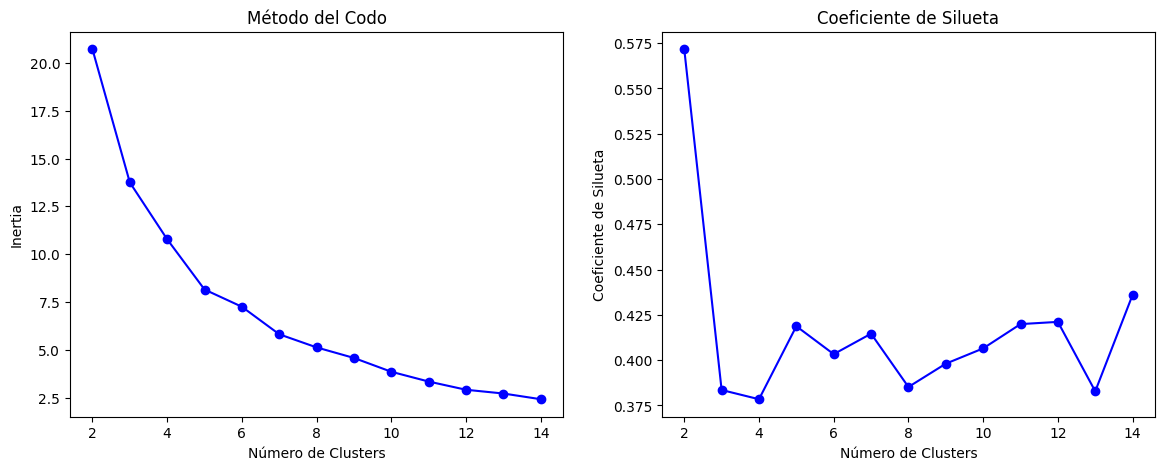

In [16]:
# Asegurarse de que la columna geometry esté activa y definir el CRS
gdf = gdf.set_geometry('geometry')
gdf.set_crs(epsg=4326, inplace=True)

# Extraer las coordenadas lon y lat de la columna geometry
gdf['lon'] = gdf.geometry.x
gdf['lat'] = gdf.geometry.y

# Preparar los datos
coords = gdf[['lon', 'lat']]

# Método del codo
inertia = []
silhouette_scores = []
K = range(2, 15)  # Evaluar de 2 a 14 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(coords, kmeans.labels_))

# Plot del método del codo
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método del Codo')

# Plot del coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta')
plt.show()


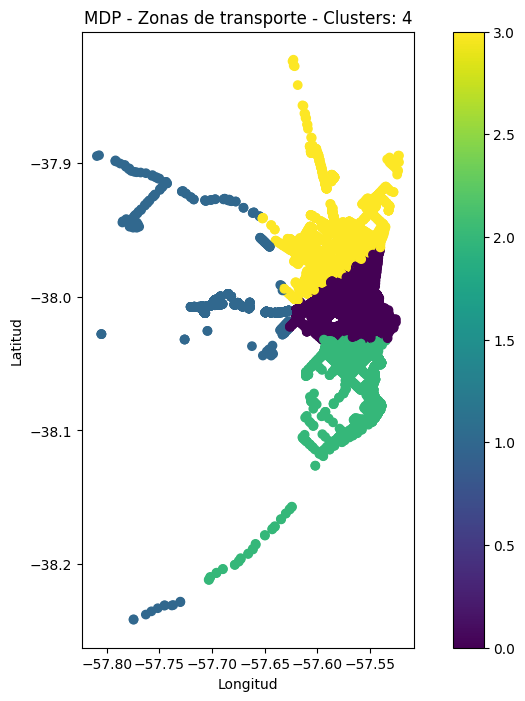

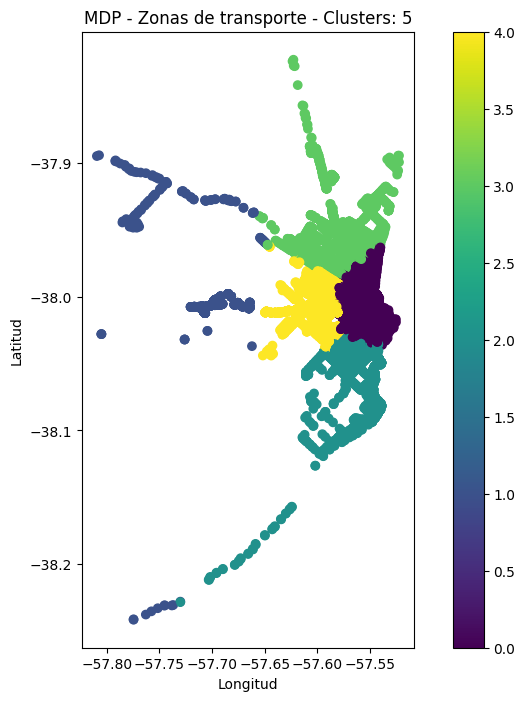

In [18]:
# Realizar la clusterización con 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=42)
gdf['cluster_4'] = kmeans_4.fit_predict(coords)

# Visualización de los clusters en el mapa (4 clusters)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='cluster_4', cmap='viridis', legend=True, ax=ax)
ax.set_title('MDP - Zonas de transporte - Clusters: 4')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

# Realizar la clusterización con 5 clusters
kmeans_5 = KMeans(n_clusters=5, random_state=42)
gdf['cluster_5'] = kmeans_5.fit_predict(coords)

# Visualización de los clusters en el mapa (5 clusters)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='cluster_5', cmap='viridis', legend=True, ax=ax)
ax.set_title('MDP - Zonas de transporte - Clusters: 5')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [19]:
# Crear polígonos convexos para cada cluster
polygons_4 = []
for cluster in gdf['cluster_4'].unique():
    points = gdf[gdf['cluster_4'] == cluster][['lon', 'lat']].values
    hull = ConvexHull(points)
    poly_points = points[hull.vertices]
    polygon = Polygon(poly_points)
    polygons_4.append({'cluster': cluster, 'geometry': polygon})

# Crear un GeoDataFrame con los polígonos
gdf_polygons_4 = gpd.GeoDataFrame(polygons_4)

# Crear el mapa interactivo con polígonos de clusters
fig = px.choropleth_mapbox(gdf_polygons_4, geojson=gdf_polygons_4.geometry, locations=gdf_polygons_4.index, color='cluster',
                           mapbox_style="open-street-map", zoom=11, center={"lat": gdf['lat'].mean(), "lon": gdf['lon'].mean()},
                           opacity=0.5, title="Clusterización geográfica de zonas de transporte con polígonos de clusters")

# Mostrar el mapa interactivo
fig.show()

# Creamos polígonos convexos para cada cluster
polygons_5 = []
for cluster in gdf['cluster_5'].unique():
    points = gdf[gdf['cluster_5'] == cluster][['lon', 'lat']].values
    hull = ConvexHull(points)
    poly_points = points[hull.vertices]
    polygon = Polygon(poly_points)
    polygons_5.append({'cluster': cluster, 'geometry': polygon})

# Creamos un GeoDataFrame con los polígonos
gdf_polygons_5 = gpd.GeoDataFrame(polygons_5)

# Creamos el mapa interactivo con polígonos de clusters
fig = px.choropleth_mapbox(gdf_polygons_5, geojson=gdf_polygons_5.geometry, locations=gdf_polygons_5.index, color='cluster',
                           mapbox_style="open-street-map", zoom=11, center={"lat": gdf['lat'].mean(), "lon": gdf['lon'].mean()},
                           opacity=0.5, title="Clusterización geográfica de zonas de transporte con polígonos de clusters", width=900, height=900)

# Mostramos el mapa interactivo
fig.show()

Para corroborar las escalas veamos los consumos mensualizados

In [20]:
# Verificar valores únicos de las columnas relevantes
unique_values = {
    'MONTH': df['MONTH'].unique(),
    'YEAR': df['YEAR'].unique(),
    'LINE_ID': df['LINE_ID'].unique(),
    'TICKETS': df['TICKETS'].unique()
}

unique_values

# Realizar la agregación por mes y año
aggregated_tickets = df.groupby(['YEAR', 'MONTH'])['TICKETS'].sum().reset_index()

# Mostrar la agregación
aggregated_tickets

,YEAR,MONTH,TICKETS
0,2020,1,8690581
1,2020,2,7910665
2,2020,3,4982272
3,2020,4,1135963
4,2020,5,1586435
5,2020,6,2014315
6,2020,7,1608452
7,2020,8,2307237
8,2020,9,1765965
9,2020,10,2314991


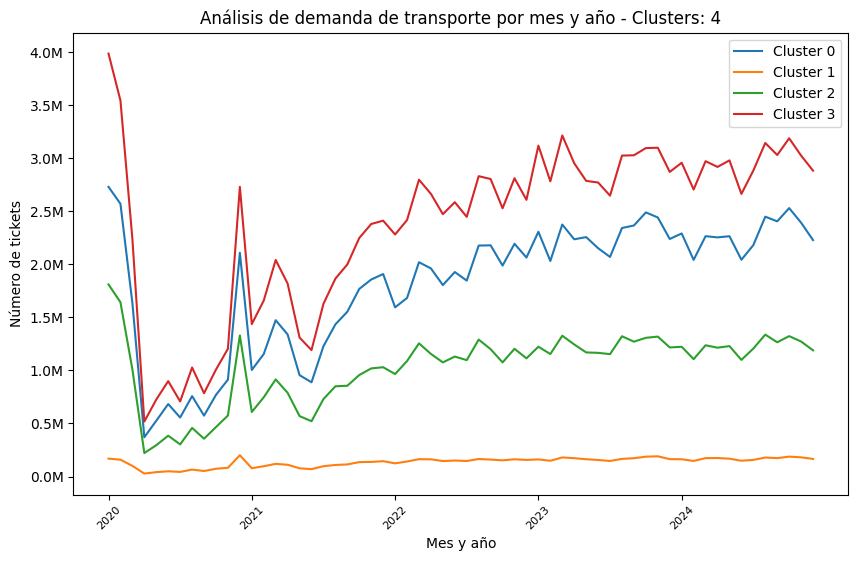

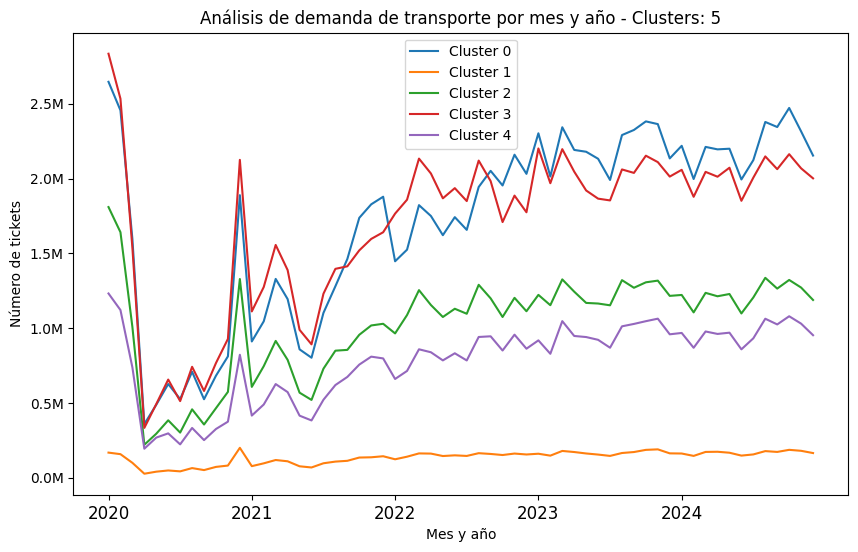

In [32]:
# Función para formatear los valores del eje Y
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

# Agrupamos los datos de gdf por LINE_ID para obtener un único registro por línea de transporte
gdf_grouped = gdf.groupby('LINE_ID').agg({'cluster_5': 'first', 'cluster_4': 'first'}).reset_index()

# Integramos datos de demanda mensualizada con los clusters
gdf_merged = gdf_grouped.merge(df, left_on='LINE_ID', right_on='LINE_ID')

# Análisis por cluster, año y mes (4 clusters)
cluster_analysis_4 = gdf_merged.groupby(['cluster_4', 'YEAR', 'MONTH']).agg({'TICKETS': 'sum'}).reset_index()

# Visualizamos análisis por cluster, año y mes (4 clusters)
fig, ax = plt.subplots(figsize=(10, 6))
for cluster in cluster_analysis_4['cluster_4'].unique():
    cluster_data = cluster_analysis_4[cluster_analysis_4['cluster_4'] == cluster]
    ax.plot(cluster_data['YEAR'].astype(str) + '-' + cluster_data['MONTH'].astype(str), cluster_data['TICKETS'], label=f'Cluster {cluster}')

ax.set_xlabel('Mes y año')
ax.set_ylabel('Número de tickets')
ax.set_title('Análisis de demanda de transporte por mes y año - Clusters: 4')
ax.legend()
plt.xticks(rotation=45, fontsize=8)
ax.yaxis.set_major_formatter(formatter)

# Ajustamos los ticks del eje X para mostrar solo los años
ticks = cluster_analysis_4['YEAR'].unique()
ax.set_xticks([f"{year}-1" for year in ticks])
ax.set_xticklabels(ticks)
plt.show()

# Análisis por cluster, año y mes (5 clusters)
cluster_analysis_5 = gdf_merged.groupby(['cluster_5', 'YEAR', 'MONTH']).agg({'TICKETS': 'sum'}).reset_index()

# Visualizar análisis por cluster, año y mes (5 clusters)
fig, ax = plt.subplots(figsize=(10, 6))
for cluster in cluster_analysis_5['cluster_5'].unique():
    cluster_data = cluster_analysis_5[cluster_analysis_5['cluster_5'] == cluster]
    ax.plot(cluster_data['YEAR'].astype(str) + '-' + cluster_data['MONTH'].astype(str), cluster_data['TICKETS'], label=f'Cluster {cluster}')

ax.set_xlabel('Mes y año')
ax.set_ylabel('Número de tickets')
ax.set_title('Análisis de demanda de transporte por mes y año - Clusters: 5')
ax.legend()
plt.xticks(rotation=0, fontsize=12)
ax.yaxis.set_major_formatter(formatter)

# Ajustar los ticks del eje X para mostrar solo los años
ticks = cluster_analysis_5['YEAR'].unique()
ax.set_xticks([f"{year}-1" for year in ticks])
ax.set_xticklabels(ticks)

plt.show()
